In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import scipy

In [3]:
telcom = pd.read_csv("~/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Manipulation

In [4]:

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

In [5]:
#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

## Train/Test Split, Turn into Torch Dataset

In [6]:
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)

In [7]:
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

In [24]:
train_X_arr = torch.Tensor(train_X.values)
train_Y_arr = torch.Tensor(train_Y.values.flatten())
test_X_arr = torch.Tensor(test_X.values)
test_Y_arr = torch.Tensor(test_Y.values.flatten())

train = torch.utils.data.TensorDataset(train_X_arr, train_Y_arr)
val = torch.utils.data.TensorDataset(test_X_arr, test_Y_arr)
train_loader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=256, shuffle=False)

In [25]:
input_dim = train_X_arr.shape[1]

In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [58]:
def auc_loss(y_pred, y_true):
    '''Soft version of AUC that uses Wilcoxon-Mann-Whitney U. statistic'''
    
    # Grab the logits of all the positive and negative examples
    pos = y_pred[y_true.view(-1, 1).bool()].view(1, -1)
    neg = y_pred[~y_true.view(-1, 1).bool()].view(-1, 1)
    gamma = 0.7
    p = 3
    difference = torch.zeros_like(pos * neg) + pos - neg - gamma
    masked = difference[difference < 0.0]
    return torch.sum(torch.pow(-masked, p))

In [56]:
device = torch.device('cpu')

comparison_dict = {}
for criterion in ['auc', 'bce']:
    net = nn.Sequential(
          nn.Linear(input_dim, 64),
          nn.ReLU(),
          nn.Linear(64, 1),
          nn.Sigmoid()
          ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.01)
    EPOCHS = 100
    bce = nn.BCEWithLogitsLoss()
    net.train()
    for e in range(1, EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = net(X_batch)
            if criterion == 'bce':
                loss = bce(y_pred, y_batch.unsqueeze(1))
            else:
                loss = auc_loss(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


#         print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

    y_pred_list = []
    net.eval()
    with torch.no_grad():
        y_test_pred = net(torch.Tensor(test_X.values))
        y_test_pred = y_test_pred
        probabilities = y_test_pred.cpu().numpy()
        y_pred_tag = torch.round(y_test_pred).cpu().numpy()
    
    comparison_dict[criterion] = {'labels': test_Y.values, 'predictions': y_pred_tag, 'logits': probabilities}

        
        

bce Classification report : 
               precision    recall  f1-score   support

           0       0.72      1.00      0.84      1268
           1       0.00      0.00      0.00       490

    accuracy                           0.72      1758
   macro avg       0.36      0.50      0.42      1758
weighted avg       0.52      0.72      0.60      1758

bce Accuracy Score   :  0.7212741751990899
bce Area under curve :  0.5
auc Classification report : 
               precision    recall  f1-score   support

           0       0.72      1.00      0.84      1268
           1       0.00      0.00      0.00       490

    accuracy                           0.72      1758
   macro avg       0.36      0.50      0.42      1758
weighted avg       0.52      0.72      0.60      1758

auc Accuracy Score   :  0.7212741751990899
auc Area under curve :  0.5


/Users/ericfrank/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ericfrank/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0,0.5,'True positive rate')

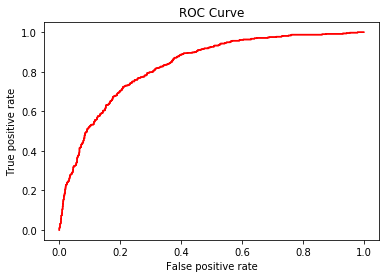

In [57]:
for criterion in ['bce', 'auc']:
    
    print (f"{criterion} Classification report : \n",classification_report(test_Y.values, y_pred_tag))
    print (f"{criterion} Accuracy Score   : ",accuracy_score(test_Y.values, y_pred_tag))
    # #confusion matrix
    # conf_matrix = confusion_matrix(test_Y.values, y_pred_tag)
    #roc_auc_score
    model_roc_auc = roc_auc_score(test_Y.values, y_pred_tag)
    print (f"{criterion} Area under curve : ",model_roc_auc)

    fpr,tpr,thresholds = roc_curve(test_Y.values, probabilities)
    plt.plot(fpr,tpr,color='Red', label=criterion)
#plot roc curve
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


In [61]:
device = torch.device('cpu')

comparison_dict = {}
for criterion in ['auc', 'bce']:
    net = nn.Sequential(
          nn.Linear(input_dim, 128),
          nn.ReLU(),
          nn.Linear(128, 1),
          nn.Sigmoid()
          ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    EPOCHS = 50
    bce = nn.BCEWithLogitsLoss()
    net.train()
    for e in range(1, EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = net(X_batch)
            if criterion == 'bce':
                loss = bce(y_pred, y_batch.unsqueeze(1))
            else:
                loss = auc_loss(y_pred, y_batch) #+ bce(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


#         print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

    y_pred_list = []
    net.eval()
    with torch.no_grad():
        y_test_pred = net(torch.Tensor(test_X.values))
        y_test_pred = y_test_pred
        probabilities = y_test_pred.cpu().numpy()
        y_pred_tag = torch.round(y_test_pred).cpu().numpy()
    
    comparison_dict[criterion] = {'labels': test_Y.values, 'predictions': y_pred_tag, 'logits': probabilities}



bce Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      1268
           1       0.73      0.31      0.44       490

    accuracy                           0.78      1758
   macro avg       0.76      0.63      0.65      1758
weighted avg       0.77      0.78      0.74      1758

bce Accuracy Score   :  0.7764505119453925
MannwhitneyuResult(statistic=1298283.0, pvalue=8.240263619086806e-33)
bce Area under curve :  0.8365294856112793

auc Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.70      0.77      1268
           1       0.48      0.70      0.57       490

    accuracy                           0.70      1758
   macro avg       0.67      0.70      0.67      1758
weighted avg       0.75      0.70      0.72      1758

auc Accuracy Score   :  0.70193401592719
MannwhitneyuResult(statistic=1339596.0, pvalue=5.258272528861601e-17)
auc Area under cu

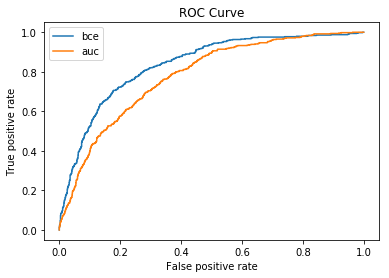

In [68]:
for criterion in ['bce', 'auc']:
    results = comparison_dict[criterion]
    print (f"\n{criterion} Classification report : \n",classification_report(results['labels'], results['predictions']))
    print (f"{criterion} Accuracy Score   : ",accuracy_score(results['labels'], results['predictions']))
    
    print(scipy.stats.mannwhitneyu(results['labels'], results['predictions']))
    # #confusion matrix
    # conf_matrix = confusion_matrix(test_Y.values, y_pred_tag)
    #roc_auc_score
    model_roc_auc = roc_auc_score(results['labels'], results['logits'])
    print (f"{criterion} Area under curve : ",model_roc_auc)

    fpr,tpr,thresholds = roc_curve(results['labels'], results['logits'])
    plt.plot(fpr,tpr, label=criterion)

#plot roc curve
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

In [48]:
thresholds

array([2., 1., 0.], dtype=float32)